In [4]:
from pathlib import Path

import torch
import SimpleITK as sitk
from fireants.io.image import Image as FAImage, BatchedImages
from fireants.registration.affine import AffineRegistration
from fireants.registration.syn import SyNRegistration


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [5]:
FIXED_PATH = Path("/mnt/nas_jlarsch/03_Common_Use/reference brains/ref_05_LB_Perrino_2p/average_2p_noRot_8bit_flipX_reverse.nrrd")
MOVING_PATH = Path("/mnt/nas_jlarsch/07_Data/Matilde/L395_f10/02_reg/00_preprocessing/2p_anatomy/L395_f10_anatomy_2P_GCaMP.nrrd")
OUTPUT_DIR = Path("/mnt/f/Johannes/testOutput/fireants").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Fixed:  {FIXED_PATH}")
print(f"Moving: {MOVING_PATH}")
print(f"Outputs will be written to: {OUTPUT_DIR}")

Fixed:  /mnt/nas_jlarsch/03_Common_Use/reference brains/ref_05_LB_Perrino_2p/average_2p_noRot_8bit_flipX_reverse.nrrd
Moving: /mnt/nas_jlarsch/07_Data/Matilde/L395_f10/02_reg/00_preprocessing/2p_anatomy/L395_f10_anatomy_2P_GCaMP.nrrd
Outputs will be written to: /mnt/f/Johannes/testOutput/fireants


## Inspect input metadata and geometry
We want to catch mismatches in voxel spacing, orientation, and physical coverage before launching registration. The summary below prints what SimpleITK reports for each stack together with derived physical extents (voxel count × spacing).

In [6]:
def describe_image(path):
    img = sitk.ReadImage(str(path))
    size = img.GetSize()
    spacing = img.GetSpacing()
    direction = img.GetDirection()
    origin = img.GetOrigin()
    extent_mm = tuple(round(s * sp, 3) for s, sp in zip(size, spacing))
    return {
        "path": str(path),
        "size": size,
        "spacing": spacing,
        "direction": direction,
        "origin": origin,
        "extent_mm": extent_mm,
        "dtype": img.GetPixelIDTypeAsString(),
        "components": img.GetNumberOfComponentsPerPixel(),
    }

metadata_summary = []
for label, path in [("fixed", FIXED_PATH), ("moving", MOVING_PATH)]:
    info = describe_image(path)
    info["label"] = label
    metadata_summary.append(info)
    print(f"{label.upper()} -> size: {info['size']}, spacing: {info['spacing']}, extent (mm): {info['extent_mm']}")
    print(f"           direction: {info['direction']}")
    print(f"           origin   : {info['origin']}, dtype: {info['dtype']}, components: {info['components']}")
    print()

metadata_summary

FIXED -> size: (512, 512, 183), spacing: (1.0, 1.0, 1.0), extent (mm): (512.0, 512.0, 183.0)
           direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
           origin   : (0.0, 0.0, 0.0), dtype: 8-bit unsigned integer, components: 1

MOVING -> size: (750, 750, 206), spacing: (0.7156817118326824, 0.7156817118326824, 1.0), extent (mm): (536.761, 536.761, 206.0)
           direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
           origin   : (0.0, 0.0, 0.0), dtype: 8-bit unsigned integer, components: 1

MOVING -> size: (750, 750, 206), spacing: (0.7156817118326824, 0.7156817118326824, 1.0), extent (mm): (536.761, 536.761, 206.0)
           direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
           origin   : (0.0, 0.0, 0.0), dtype: 8-bit unsigned integer, components: 1



[{'path': '/mnt/nas_jlarsch/03_Common_Use/reference brains/ref_05_LB_Perrino_2p/average_2p_noRot_8bit_flipX_reverse.nrrd',
  'size': (512, 512, 183),
  'spacing': (1.0, 1.0, 1.0),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, 0.0, 0.0),
  'extent_mm': (512.0, 512.0, 183.0),
  'dtype': '8-bit unsigned integer',
  'components': 1,
  'label': 'fixed'},
 {'path': '/mnt/nas_jlarsch/07_Data/Matilde/L395_f10/02_reg/00_preprocessing/2p_anatomy/L395_f10_anatomy_2P_GCaMP.nrrd',
  'size': (750, 750, 206),
  'spacing': (0.7156817118326824, 0.7156817118326824, 1.0),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
  'origin': (0.0, 0.0, 0.0),
  'extent_mm': (536.761, 536.761, 206.0),
  'dtype': '8-bit unsigned integer',
  'components': 1,
  'label': 'moving'}]

In [7]:
RESAMPLE_MOVING_TO_FIXED = True
INTENSITY_NORMALIZE = True

fixed_sitk = sitk.Cast(sitk.ReadImage(str(FIXED_PATH)), sitk.sitkFloat32)
moving_sitk = sitk.Cast(sitk.ReadImage(str(MOVING_PATH)), sitk.sitkFloat32)

initial_centering = sitk.CenteredTransformInitializer(
    fixed_sitk,
    moving_sitk,
    sitk.AffineTransform(3),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
 )

if RESAMPLE_MOVING_TO_FIXED:
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_sitk)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0.0)
    resampler.SetTransform(initial_centering)
    moving_preprocessed_sitk = resampler.Execute(moving_sitk)
else:
    moving_preprocessed_sitk = moving_sitk

if INTENSITY_NORMALIZE:
    fixed_preprocessed_sitk = sitk.RescaleIntensity(fixed_sitk, 0.0, 1.0)
    moving_preprocessed_sitk = sitk.RescaleIntensity(moving_preprocessed_sitk, 0.0, 1.0)
else:
    fixed_preprocessed_sitk = fixed_sitk

print("Fixed preprocessed size:", fixed_preprocessed_sitk.GetSize(), "spacing:", fixed_preprocessed_sitk.GetSpacing())
print("Moving preprocessed size:", moving_preprocessed_sitk.GetSize(), "spacing:", moving_preprocessed_sitk.GetSpacing())

Fixed preprocessed size: (512, 512, 183) spacing: (1.0, 1.0, 1.0)
Moving preprocessed size: (512, 512, 183) spacing: (1.0, 1.0, 1.0)


### Notes on preprocessing choices
- `RESAMPLE_MOVING_TO_FIXED` uses the fixed stack as a reference grid and recenters the moving volume before resampling so physical voxel spacing and extents line up. Toggle it off if you prefer native sampling and handle scale differences inside the optimizer instead.
- `INTENSITY_NORMALIZE` rescales both inputs to `[0, 1]`. Disable it if downstream steps expect raw 8-bit intensities.

In [8]:
fixed_fa_image = FAImage(fixed_preprocessed_sitk, device=device, dtype=torch.float32)
moving_fa_image = FAImage(moving_preprocessed_sitk, device=device, dtype=torch.float32)

fixed_batch = BatchedImages(fixed_fa_image)
moving_batch = BatchedImages(moving_fa_image)

print(f"Fixed FireANTs tensor: {tuple(fixed_fa_image.array.shape)}")
print(f"Moving FireANTs tensor: {tuple(moving_fa_image.array.shape)}")

Fixed FireANTs tensor: (1, 1, 183, 512, 512)
Moving FireANTs tensor: (1, 1, 183, 512, 512)


In [9]:
affine = AffineRegistration(
    [4, 2, 1],
    [1000, 500, 250],
    fixed_batch,
    moving_batch,
    optimizer="Adam",
    optimizer_lr=0.05,
    cc_kernel_size=5,
)
affine.optimize()
affine_warp = affine.evaluate(fixed_batch, moving_batch)

affine_transform_path = OUTPUT_DIR / "affine_transform.mat"
affine.save_as_ants_transforms(str(affine_transform_path))
print(f"Saved affine transform to {affine_transform_path}")


INFO:fireants.registration.abstract:Registration of type AffineRegistration initialized with dtype torch.float32


scale: 1, iter: 249/250, loss: -0.997801: 100%|██████████| 250/250 [02:14<00:00,  1.86it/s]
INFO:fireants.registration.affine:Saved transform to /mnt/f/Johannes/testOutput/fireants/affine_transform.mat

INFO:fireants.registration.affine:Saved transform to /mnt/f/Johannes/testOutput/fireants/affine_transform.mat


Saved affine transform to /mnt/f/Johannes/testOutput/fireants/affine_transform.mat


In [10]:
syn = SyNRegistration(
    [4, 2, 1],
    [200, 100, 50],
    fixed_batch,
    moving_batch,
    optimizer="Adam",
    optimizer_lr=0.05,
    cc_kernel_size=5,
    smooth_grad_sigma=1.0,
    smooth_warp_sigma=0.5,
    init_affine=affine.get_affine_matrix(homogenous=True),
)
syn.optimize()
syn_warp = syn.evaluate(fixed_batch, moving_batch)

syn_forward_path = OUTPUT_DIR / "syn_forward_warp.nii.gz"
syn_inverse_path = OUTPUT_DIR / "syn_inverse_warp.nii.gz"
syn.save_as_ants_transforms(str(syn_forward_path))
#syn.save_as_ants_transforms(str(syn_inverse_path), save_inverse=True)
print(f"Saved SyN transforms to {syn_forward_path} and {syn_inverse_path}")


INFO:fireants.registration.abstract:Registration of type SyNRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: -0.998287: 100%|██████████| 50/50 [01:38<00:00,  1.97s/it]
INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32

INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: 0.000000: 100%|██████████| 50/50 [02:37<00:00,  3.14s/it]
INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: 0.000000: 100%|██████████| 50/50 [02:37<00:00,  3.14s/it]
INFO:fireants.registration.abstract:Registration of type GreedyRegistration initialized with dtype torch.float32
scale: 1, iter: 49/50, loss: 0.000000: 100%|██████████| 50/50 [02:13<00:00,  2.67s/it]



Saved SyN transforms to /mnt/f/Johannes/testOutput/fireants/syn_forward_warp.nii.gz and /mnt/f/Johannes/testOutput/fireants/syn_inverse_warp.nii.gz


In [11]:
def tensor_to_sitk(tensor, reference_image):
    array = tensor.squeeze().detach().cpu().numpy()
    image = sitk.GetImageFromArray(array.astype("float32"))
    image.CopyInformation(reference_image.itk_image)
    return image

affine_image = tensor_to_sitk(affine_warp, fixed_fa_image)
syn_image = tensor_to_sitk(syn_warp, fixed_fa_image)

affine_output_path = OUTPUT_DIR / "moving_affine_warped.nrrd"
syn_output_path = OUTPUT_DIR / "moving_syn_warped.nrrd"

sitk.WriteImage(affine_image, str(affine_output_path))
sitk.WriteImage(syn_image, str(syn_output_path))

print(f"Affine warped volume written to {affine_output_path}")
print(f"SyN warped volume written to {syn_output_path}")

Affine warped volume written to /mnt/f/Johannes/testOutput/fireants/moving_affine_warped.nrrd
SyN warped volume written to /mnt/f/Johannes/testOutput/fireants/moving_syn_warped.nrrd


Text(0.5, 1.0, 'Overlap')

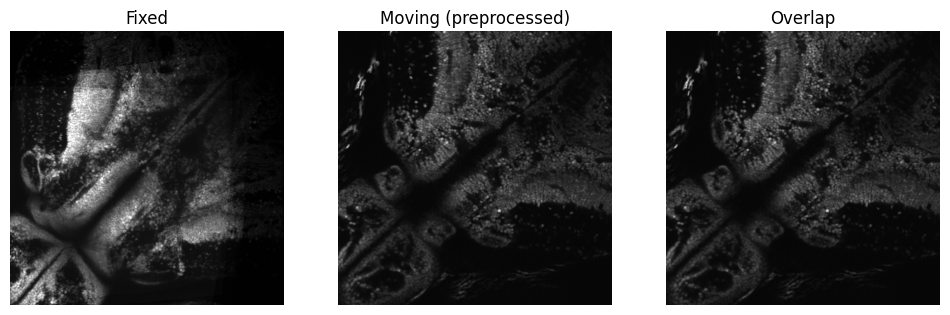

In [13]:
idx = 100
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(sitk.GetArrayFromImage(fixed_preprocessed_sitk)[idx], cmap='gray'); plt.axis('off'); plt.title('Fixed')
plt.subplot(1, 3, 2); plt.imshow(sitk.GetArrayFromImage(moving_preprocessed_sitk)[idx], cmap='gray'); plt.axis('off'); plt.title('Moving (preprocessed)')
plt.subplot(1, 3, 3); plt.imshow(sitk.GetArrayFromImage(moving_preprocessed_sitk)[idx], cmap='gray'); plt.axis('off'); plt.title('Overlap')

FOUND   -> /mnt/f/Johannes/testOutput/fireants/moving_affine_warped.nrrd
FOUND   -> /mnt/f/Johannes/testOutput/fireants/moving_syn_warped.nrrd
FOUND   -> /mnt/f/Johannes/testOutput/fireants/affine_transform.mat
FOUND   -> /mnt/f/Johannes/testOutput/fireants/syn_forward_warp.nii.gz
missing -> /mnt/f/Johannes/testOutput/fireants/syn_inverse_warp.nii.gz



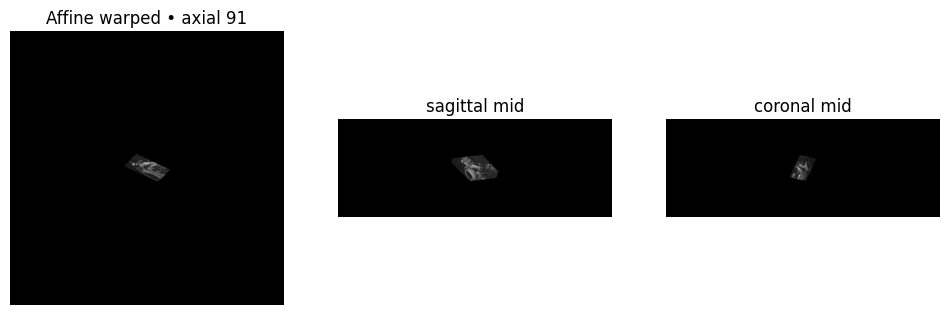

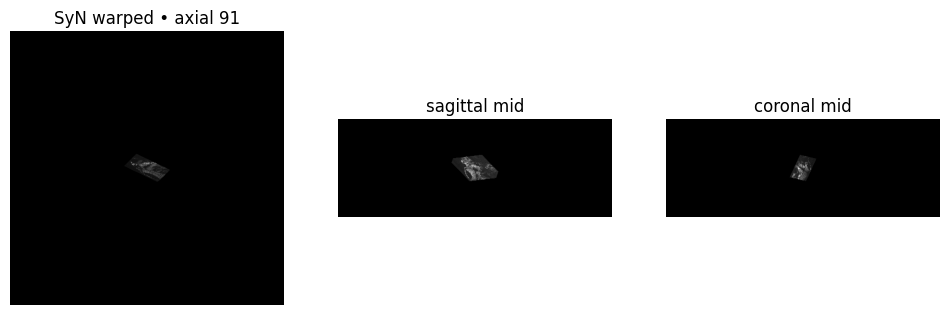

In [14]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

output_files = {
    "affine_warp": OUTPUT_DIR / "moving_affine_warped.nrrd",
    "syn_warp": OUTPUT_DIR / "moving_syn_warped.nrrd",
    "affine_mat": OUTPUT_DIR / "affine_transform.mat",
    "syn_forward": OUTPUT_DIR / "syn_forward_warp.nii.gz",
    "syn_inverse": OUTPUT_DIR / "syn_inverse_warp.nii.gz",
}

for name, path in output_files.items():
    status = "FOUND" if path.exists() else "missing"
    print(f"{status:7s} -> {path}")
print()

def preview_volume(path, title):
    img = sitk.ReadImage(str(path))
    arr = sitk.GetArrayFromImage(img)
    mid = arr.shape[0] // 2
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(arr[mid], cmap="gray"); plt.axis("off"); plt.title(f"{title} • axial {mid}")
    plt.subplot(1, 3, 2); plt.imshow(arr[:, arr.shape[1]//2, :], cmap="gray"); plt.axis("off"); plt.title("sagittal mid")
    plt.subplot(1, 3, 3); plt.imshow(arr[:, :, arr.shape[2]//2], cmap="gray"); plt.axis("off"); plt.title("coronal mid")
    plt.show()

if output_files["affine_warp"].exists():
    preview_volume(output_files["affine_warp"], "Affine warped")

if output_files["syn_warp"].exists():
    preview_volume(output_files["syn_warp"], "SyN warped")

In [15]:
import numpy as np

A = affine.get_affine_matrix(homogenous=False)[0].detach().cpu().numpy()
linear, transl = A[:, :3], A[:, 3]
print("Linear part:\n", linear)
print("Translation:", transl)
print("Singular values:", np.linalg.svd(linear, compute_uv=False))

Linear part:
 [[  5.449358    5.617837    1.8573604]
 [ -1.3169483   2.5427275 -11.013638 ]
 [ -2.568402    5.367336    2.4962368]]
Translation: [-2739.9465    944.84155  -849.0035 ]
Singular values: [11.595763   8.487673   5.4165735]


### Quick slice comparison
To verify alignment, use the slider below to browse axial slices across fixed, affine-warped, and SyN-warped volumes. Toggle the checkboxes to adjust overlays.

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Checkbox
import numpy as np

# Use lightweight array views to avoid copying all voxels at once
fixed_view = sitk.GetArrayViewFromImage(fixed_preprocessed_sitk)
moving_view = sitk.GetArrayViewFromImage(moving_preprocessed_sitk)
affine_view = sitk.GetArrayViewFromImage(affine_image) if 'affine_image' in locals() else None
syn_view = sitk.GetArrayViewFromImage(syn_image) if 'syn_image' in locals() else None

def _safe_slice(view, idx):
    if view is None:
        return None
    idx = max(0, min(idx, view.shape[0] - 1))  # clamp to bounds
    return np.asarray(view[idx]).astype(np.float32)

def show_slices(idx, show_moving=True, show_affine=True, show_syn=True):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Axial slice {idx}")

    fixed_slice = _safe_slice(fixed_view, idx)
    axes[0].imshow(fixed_slice, cmap='gray')
    axes[0].set_title('Fixed')
    axes[0].axis('off')

    if show_moving:
        moving_slice = _safe_slice(moving_view, idx)
        axes[1].imshow(moving_slice, cmap='gray')
        axes[1].set_title('Preprocessed Moving')
        axes[1].axis('off')
    else:
        axes[1].remove()

    if show_affine and affine_view is not None:
        affine_slice = _safe_slice(affine_view, idx)
        axes[2].imshow(affine_slice, cmap='gray')
        axes[2].set_title('Affine warped')
        axes[2].axis('off')
    else:
        axes[2].remove()

    if show_syn and syn_view is not None:
        syn_slice = _safe_slice(syn_view, idx)
        axes[3].imshow(syn_slice, cmap='gray')
        axes[3].set_title('SyN warped')
        axes[3].axis('off')
    else:
        axes[3].remove()

    plt.tight_layout()
    plt.show()

max_idx = fixed_view.shape[0] - 1
interact(
    show_slices,
    idx=IntSlider(value=max_idx // 2, min=0, max=max_idx, step=1, description='Slice'),
    show_moving=Checkbox(value=True, description='Show moving'),
    show_affine=Checkbox(value=True, description='Show affine'),
    show_syn=Checkbox(value=True, description='Show SyN')
);

In [12]:
import os
from pathlib import Path

expected_outputs = [
    OUTPUT_DIR / "moving_affine_warped.nrrd",
    OUTPUT_DIR / "moving_syn_warped.nrrd",
    OUTPUT_DIR / "affine_transform.mat",
    OUTPUT_DIR / "syn_forward_warp.nii.gz",
    OUTPUT_DIR / "syn_inverse_warp.nii.gz",
]

for path in expected_outputs:
    status = "FOUND" if path.exists() else "missing"
    print(f"{status:7s} -> {path}")

FOUND   -> /mnt/f/Johannes/testOutput/fireants/moving_affine_warped.nrrd
FOUND   -> /mnt/f/Johannes/testOutput/fireants/moving_syn_warped.nrrd
FOUND   -> /mnt/f/Johannes/testOutput/fireants/affine_transform.mat
FOUND   -> /mnt/f/Johannes/testOutput/fireants/syn_forward_warp.nii.gz
missing -> /mnt/f/Johannes/testOutput/fireants/syn_inverse_warp.nii.gz


In [28]:
import os, sys, shlex, subprocess

# --- config ---
cfg_dir  = "/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration"
cfg_name = "template"  # because your file is template.yaml

# pick GPU count automatically (>=1). if CUDA not available, keep it at 1; the script may still require CUDA.
try:
    import torch
    nproc = max(1, torch.cuda.device_count())
except Exception:
    nproc = 1

# clearer Hydra errors + keep outputs in current working dir
env = os.environ.copy()
env["HYDRA_FULL_ERROR"] = "1"

cmd = [
    sys.executable, "-m", "torch.distributed.run",
    "--nproc_per_node", str(nproc),
    "-m", "fireants.scripts.template.build_template",
    "--config-path", cfg_dir,
    "--config-name", cfg_name,
    "hydra.run.dir=."
]

print("Running:\n", " ".join(shlex.quote(c) for c in cmd), "\n")

# stream output live
p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, env=env)
for line in p.stdout:
    print(line, end="")
ret = p.wait()
print(f"\n\nProcess exited with code {ret}")


Running:
 /home/jlarsch/miniforge3/envs/fireants/bin/python -m torch.distributed.run --nproc_per_node 1 -m fireants.scripts.template.build_template --config-path /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration --config-name template hydra.run.dir=. 

USE_FFO: True
FFO_AVAILABLE: True
Using FFO: True
[2025-09-30 01:26:16,727][build_template][INFO] - Working directory: /home/jlarsch/social_imaging_scripts/exampleNotebooks
[2025-09-30 01:26:16,728][build_template][INFO] - Output directory: /home/jlarsch/social_imaging_scripts/exampleNotebooks
[2025-09-30 01:26:16,728][build_template][DEBUG] - Debug mode activated.
[2025-09-30 01:26:16,728][build_template][INFO] - Setting up distributed training with local rank 0 and world size 1.
data parallel size 1
grid parallel size 1
Rank 0 is in the grid parallel group [0]
Rank 0 is in the data parallel group [0]
[2025-09-30 01:26:19,997][build_template][INFO] - Using provided template: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/average_2p

In [23]:
from pathlib import Path

# EDIT this to the folder where your subject volumes live
imgs_dir = Path("/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs")

paths = sorted(str(p) for p in imgs_dir.glob("*.nrrd"))  # or *.nii.gz
list_path = Path("/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/image_list.txt")
list_path.write_text("\n".join(paths) + "\n")
print(f"Wrote {len(paths)} paths to {list_path}")

Wrote 5 paths to /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/image_list.txt


In [25]:
from pathlib import Path
import SimpleITK as sitk

list_file = Path("/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/image_list.txt")
paths = [p.strip() for p in list_file.read_text().splitlines() if p.strip()]

def info(p):
    img = sitk.ReadImage(p)
    return {
        "path": p,
        "size": img.GetSize(),          # (x,y,z)
        "spacing": img.GetSpacing(),    # (sx,sy,sz)
        "direction": img.GetDirection(),
        "origin": img.GetOrigin(),
        "components": img.GetNumberOfComponentsPerPixel(),
        "pixel_type": img.GetPixelIDTypeAsString(),
    }

rows = [info(p) for p in paths]
for r in rows:
    print(r["path"])
    print("  size    :", r["size"])
    print("  spacing :", r["spacing"])
    print("  comps   :", r["components"], r["pixel_type"])
    print()


/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs/f14_anatomy_00001.nrrd
  size    : (512, 512, 215)
  spacing : (1.048361882567406, 1.048361882567406, 1.0)
  comps   : 1 8-bit unsigned integer

/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs/f15_anatomy_00001.nrrd
  size    : (512, 512, 217)
  spacing : (1.048361882567406, 1.048361882567406, 1.0)
  comps   : 1 8-bit unsigned integer

/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs/f16_anatomy_00001.nrrd
  size    : (512, 512, 217)
  spacing : (1.048361882567406, 1.048361882567406, 1.0)
  comps   : 1 8-bit unsigned integer

/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs/f18_anatomy_00001.nrrd
  size    : (512, 512, 213)
  spacing : (1.048361882567406, 1.048361882567406, 1.0)
  comps   : 1 8-bit unsigned integer

/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/inputs/f19_anatomy_00001.nrrd
  size    : (512, 512, 230)
  spacing : (1.048361882567406, 1.048361882567406, 1.0)
  comps   : 1 8-bit uns

In [26]:
from pathlib import Path
import SimpleITK as sitk

root = Path("/mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration")
inputs_dir = root / "inputs"
template_path = root / "average_2p_noRot.nrrd"   # as in your log
out_dir = root / "resampled_to_template_nrrd"
out_dir.mkdir(parents=True, exist_ok=True)

# Reference grid from the template
ref = sitk.ReadImage(str(template_path))
ref_size      = ref.GetSize()
ref_spacing   = ref.GetSpacing()
ref_direction = ref.GetDirection()
ref_origin    = ref.GetOrigin()

def to_scalar_float(img):
    if img.GetNumberOfComponentsPerPixel() > 1:
        img = sitk.VectorIndexSelectionCast(img, 0)
    return sitk.Cast(img, sitk.sitkFloat32)

def resample_to_ref(img):
    R = sitk.ResampleImageFilter()
    R.SetReferenceImage(ref)           # sets size/spacing/direction/origin
    R.SetInterpolator(sitk.sitkLinear) # linear for intensities
    R.SetDefaultPixelValue(0.0)
    return R.Execute(img)

# Resample all .nrrd images in inputs_dir
out_paths = []
for p in sorted(inputs_dir.glob("*.nrrd")):
    mov = sitk.ReadImage(str(p))
    mov = to_scalar_float(mov)
    rs  = resample_to_ref(mov)
    out_p = out_dir / (p.stem + "_rs.nrrd")   # keep NRRD if you prefer
    sitk.WriteImage(rs, str(out_p))
    out_paths.append(str(out_p))
    print("Wrote:", out_p)

# Write a fresh image list for FireANTs
list_path = root / "image_list_resampled.txt"
list_path.write_text("\n".join(out_paths) + "\n")
print(f"\nResampled {len(out_paths)} images to template grid {ref_size} @ {ref_spacing}")
print("New list:", list_path)


Wrote: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/resampled_to_template_nrrd/f14_anatomy_00001_rs.nrrd
Wrote: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/resampled_to_template_nrrd/f15_anatomy_00001_rs.nrrd
Wrote: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/resampled_to_template_nrrd/f16_anatomy_00001_rs.nrrd
Wrote: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/resampled_to_template_nrrd/f18_anatomy_00001_rs.nrrd
Wrote: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/resampled_to_template_nrrd/f19_anatomy_00001_rs.nrrd

Resampled 5 images to template grid (512, 512, 183) @ (1.0, 1.0, 1.0)
New list: /mnt/nas_jlarsch/Matilde/2p/AnatomyForRegistration/image_list_resampled.txt
